In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


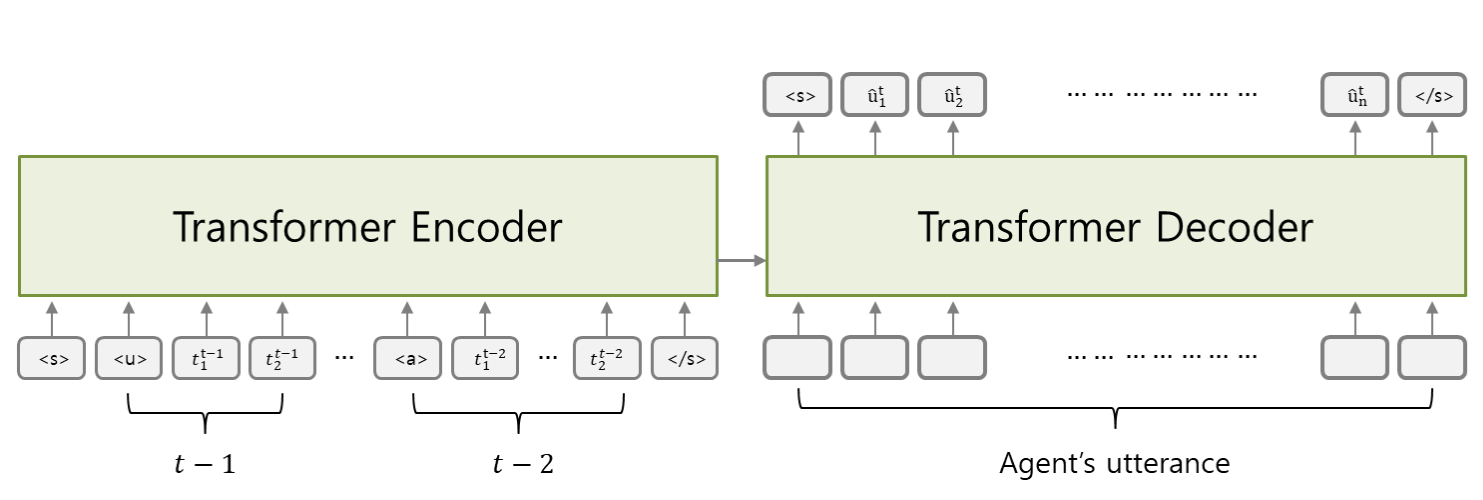

In [ ]:
from IPython.display import Image
import os
root_dir = '/gdrive/MyDrive/강의자료 모음/[2022]/03. Knowledge-grounded Chatbot/practice'
Image(os.path.join(root_dir, "Chat_practice.PNG"))

In [ ]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=6e0a1f62f7d2fb1f309808d99250fc7d17b9a268382f3aa2816f3b5555e614e8
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


In [ ]:
from torch.utils.data import (DataLoader, TensorDataset)
from torch import nn
from tqdm import tqdm
import numpy as np
import torch
import os
from rouge_score import rouge_scorer
import random
from torch.nn import MultiheadAttention
import copy
from torch.nn.init import xavier_uniform_
import math

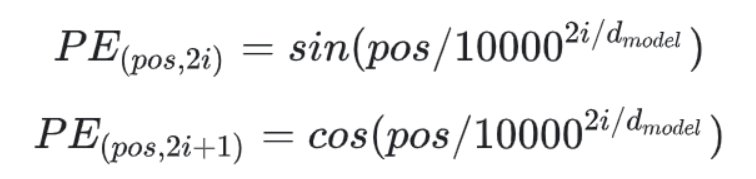

In [ ]:
Image(os.path.join(root_dir, "PositionalEncoding.PNG"))

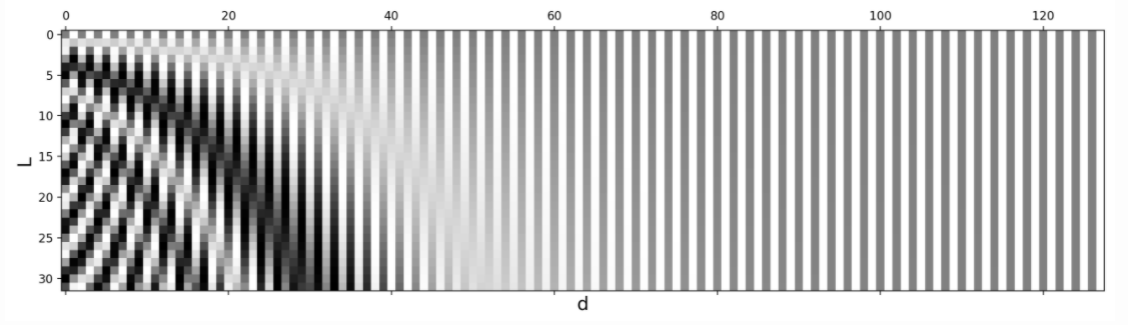

In [ ]:
Image(os.path.join(root_dir, "pe1.PNG"))

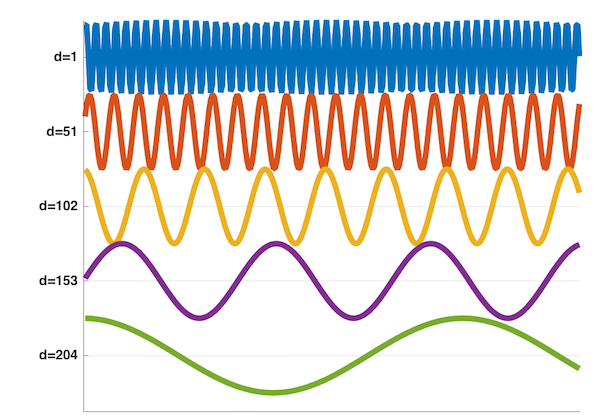

In [ ]:
Image(os.path.join(root_dir, "pe.PNG"))

In [ ]:

# module을 N개의 Layer로 확장하기 위한 함수
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

# Trm에 순차정보를 반영하기 위한 PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        # d_model : Tensor의 마지막 Dimension
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    # [max_length, 1, emb]
    def forward(self, x):
       # x : [seq, batch, emb]
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


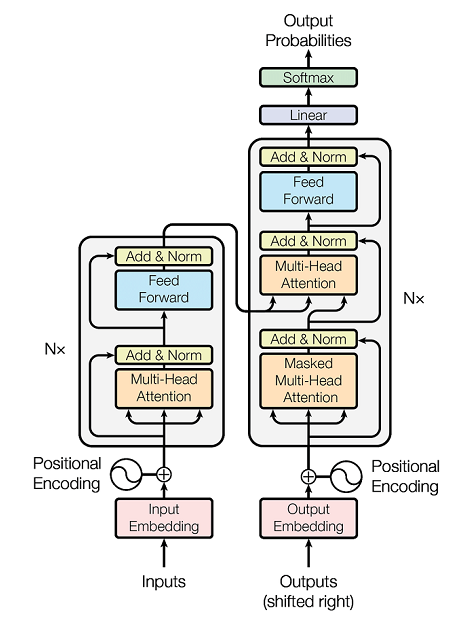

In [ ]:
Image(os.path.join(root_dir, "Transformers.PNG"))

In [ ]:
# Transformer Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(TransformerEncoderLayer, self).__init__()
        # args
        #   d_model : 입력 Tensor의 마지막 Demension의 크기
        #   nhead : Multi-head Attention에서 사용할 Attention Head 개수
        #   dim_feedforward : Trm 내부 Linear layer dim

        # 연산 Layer 중간마다 사용되는 Dropout
        self.dropout = nn.Dropout(dropout)

        # Transformer Encoder에 사용되는 Scaled Dot-product Attention (Self)
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)

        # Trm Block에서 Add & Norm에 해당하는 Batch Normalization
        # LayerNorm 내부에 학습 가능한 affine 변수가 포함되기 때문에 따로 선언
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Trm Block에서 Feed Forward에 해당하는 Layer
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(dim_feedforward, d_model)

    def forward(self, src, src_mask = None, src_key_padding_mask = None):
        # src : [enc_seq, batch, hidden]
        # src_mask (Optional): [enc_seq, enc_seq]
        #   각 입력 토큰에 대해서 계산되는 attention에 순차정보가 필요한 경우 사용
        #  ex - [[1, -inf, -inf, -inf],
        #        [1,    1, -inf, -inf],
        #        [1,    1,    1, -inf],
        #        [1,    1,    1,    1]]
        # src_key_padding_mask (Optional): [batch, enc_seq]
        #   attention 연산에 사용하지 않을 pad 위치를 담은 boolean mask
        #  ex - [True, True, ..., False, False]

        # 입력 받은 src에 대해서 Multi-Head Attention 수행
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        # src2 : [enc_seq, batch, hidden]

        ##     Add & Norm     ##
        src = src + self.dropout(src2)
        src = self.norm1(src)
        # src : [enc_seq, batch, hidden]

        ##     Feed Forward   ##
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        # src2 : [enc_seq, batch, dim_feedforward] => [enc_seq, batch, hidden]
        src = src + self.dropout(src2)
        src = self.norm2(src)
        # src : [enc_seq, batch, hidden]

        return src

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm):
        super(TransformerEncoder, self).__init__()
        # args
        #   encoder_layer : Transformer Encoder Layer
        #   num_layers : Transformer Encoder Layer 수
        #   norm : 최종 출력의 Normalization을 위한 norm

        # encoder layer를 num_layers 만큼 확장
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask = None, src_key_padding_mask = None):
        # src : [enc_seq, batch, hidden]
        # mask : [enc_seq, enc_seq]
        # src_key_padding_mask : [batch, enc_seq]

        # 레이어 수 만큼 반복하면서 각 계층의 출력을 다음 층의 입력으로 사용
        output = src
        for layer in self.layers:
            output = layer(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        # output : [enc_seq, batch, hidden]

        # 최종 Output에 Normalization 적용
        output = self.norm(output)

        return output

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(TransformerDecoderLayer, self).__init__()
        # args
        #   d_model : 입력 Tensor의 마지막 Demension의 크기
        #   nhead : Multi-head Attention에서 사용할 Attention Head 개수
        #   dim_feedforward : Trm 내부 Linear layer dim

        # Transformer Decoder에 사용되는 Scaled Dot-product Attention (Self)
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)

        # Transformer Decoder에 사용되는 Scaled Dot-product Attention (Encoder-Decoder)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout)

        # Trm Block에서 Add & Norm에 해당하는 Batch Normalization
        # LayerNorm 내부에 학습 가능한 affine 변수가 포함되기 때문에 따로 선언
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        # Trm Block에서 Feed Forward에 해당하는 Layer
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.activation = nn.GELU()

    def forward(self, tgt, memory, tgt_mask = None, memory_mask = None,
                tgt_key_padding_mask = None, memory_key_padding_mask = None):
        # tgt : [dec_seq, batch, hidden]
        # memory : [enc_seq, batch, hidden]
        # tgt_mask (Optional): [dec_seq, dec_seq]
        #
        #   의존 구문 분석과 같이 출력과 Decoder 입력이 다를 경우 => tgt_mask 없이 구현
        #   NLG와 같이 출력과 Decoder 입력이 같을 경우 => tgt_mask를 사용하여 masking
        #  ex - [[1, -inf, -inf, -inf],
        #        [1,    1, -inf, -inf],
        #        [1,    1,    1, -inf],
        #        [1,    1,    1,    1]]
        #
        # memory_mask (Optional) : [dec_seq, enc_seq]
        #   Encoder의 출력 값 반영 단계에서 다음 Step 정보 반영을 막기위해 사용하는 Mask
        #
        # tgt_key_padding_mask (Optional) : [batch, dec_seq]
        #   의존 구문 분석과 같이 출력의 길이가 입력 시퀀스에 따라 정해져 있는 경우 => Padding Masking을 통해 필요 이상의 Decoding 방지
        #   NLG와 같이 출력의 길이가 정해지지 않은 경우 => Padding Masking 없이 호출
        #
        # memory_key_padding_mask (Optional) : [batch, enc_seq]
        #   Encoder-Decoder Attention 연산에 사용하지 않을 Encoder의 pad 위치를 담은 boolean mask
        #    ex - [True, True, ..., False, False]

        # 입력 받은 tgt(Decoder Input)에 대해서 Multi-Head Attention (Self) 수행
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        # tgt2 : [dec_seq, batch, hidden]

        ##     Add & Norm     ##
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm1(tgt)
        # tgt : [dec_seq, batch, hidden]

        # 입력 받은 memory(Encoder 출력)와 tgt 에 대해서 Multi-Head Attention (Encoder-Decoder) 수행
        # 이때, Q = tgt, K = V = memory
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)
        # tgt2 : [dec_seq, batch, hidden]

        ##     Add & Norm     ##
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm2(tgt)
        # tgt : [dec_seq, batch, hidden]

        ##     Feed Forward   ##
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout(tgt2)
        tgt = self.norm3(tgt)
        # tgt : [dec_seq, batch, hidden]

        return tgt

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        # args
        #   decoder_layer : Transformer Decoder Layer
        #   num_layers : Transformer Decoder Layer 수
        #   norm : 최종 출력의 Normalization을 위한 norm

        # Decoder layer를 num_layers 만큼 확장
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt, memory, tgt_mask, memory_mask = None, tgt_key_padding_mask = None,
                memory_key_padding_mask = None):
        # tgt : [dec_seq, batch, hidden]
        # memory : [enc_seq, batch, hidden]
        # tgt_mask (Optional): [dec_seq, dec_seq]
        # memory_mask (Optional) : [dec_seq, enc_seq]
        # tgt_key_padding_mask (Optional) : [batch, dec_seq]
        # memory_key_padding_mask (Optional) : [batch, enc_seq]

        # 레이어 수 만큼 반복하면서 각 계층의 출력을 다음 층의 입력으로 사용
        output = tgt
        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)
        # output : [dec_seq, batch, hidden]

        # 최종 Output에 Normalization 적용
        output = self.norm(output)

        return output


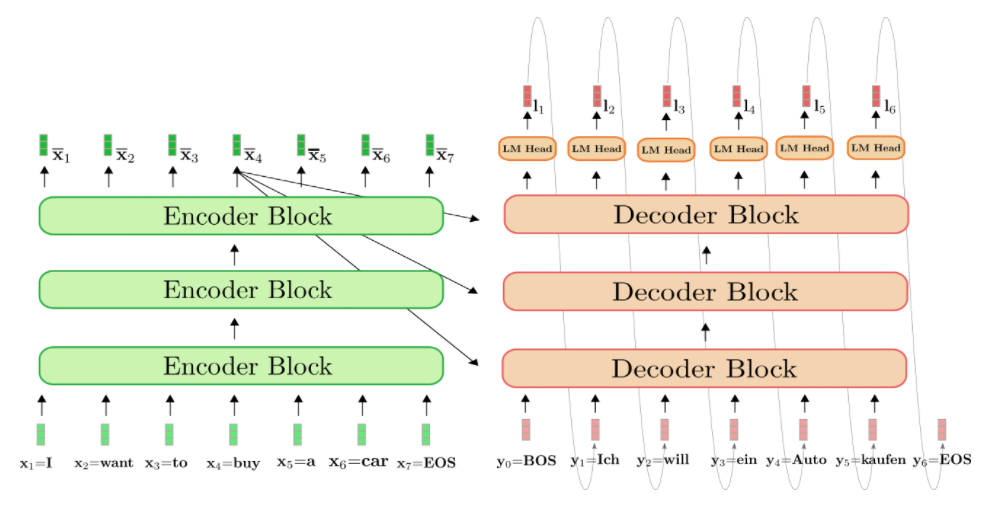

In [ ]:
Image(os.path.join(root_dir, "Transformer_seq2seq.PNG"))

In [ ]:
# 안, 녕, 하, 세, 요

# decoder input [<s>]  -> [인] [안]
# decoder output [인]  -> [녕]

In [ ]:
class Transformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers,
                 num_decoder_layers, dim_feedforward, dropout = 0.1):
        super(Transformer, self).__init__()
        # d_model : 입력 Tensor의 마지막 Dimension 크기
        # nhead : Multi-head Attention의 Head 수
        # num_encoder_layers : Transformer Encoder Layer 수
        # num_decoder_layers : Transformer Decoder Layer 수
        # dim_feedforward : Transformer 내부 Linear weight 크기

        # 순차 정보 반영을 위한 PositionEncoding 선언
        self.positional_encoding = PositionalEncoding(d_model, dropout)

        # Transformer Encoder Block을 구성하는 Transformer Encoder 선언
        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)

        # Block으로 묶인 Transformer Encoder 선언
        encoder_norm = nn.LayerNorm(d_model)
        self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        # Transformer Decoder Block을 구성하는 Transformer Decoder 선언
        decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)

        # Block으로 묶인 Transformer Decoder 선언
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        # Transformer 파라미터 초기화
        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

    def forward(self, src, tgt, src_mask = None, tgt_mask = None,
                memory_mask = None, src_key_padding_mask = None,
                tgt_key_padding_mask = None, memory_key_padding_mask = None):
        # src : [enc_seq, batch, hidden]
        # tgt : [dec_seq, batch, hidden]
        # src_mask : [enc_seq, enc_seq]
        # tgt_mask : [dec_seq, dec_seq]
        # memory_mask : [dec_seq, enc_seq]
        # src_key_padding_mask : [batch, enc_seq]
        # memory_key_padding_mask : [batch, enc_seq]

        # 입력 Tensor에 위치 정보 반영
        pos_src = self.positional_encoding(src)

        # Transformer Encoder Block 출력
        memory = self.encoder(pos_src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        # memory : [end_seq, batch, hidden]

        # Transformer Encoder Block 출력
        output = self.decoder(tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask)
        # output : [dec_seq, batch, hidden]

        return output

    # 2-D tgt_mask 생성을 위한 함수
    #       [[0, -inf, -inf, -inf],
    #        [0,    1, -inf, -inf],
    #        [0,    0,    1, -inf],
    #        [0,    0,    1,    1]]
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    # 파라미터 초기화 함수
    def _reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)


In [ ]:
# Transformer Seq2Seq 모델
class TransformerModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        # 전체 단어(word) 개수
        self.vocab_size = config["vocab_size"]

        # 단어(word) 벡터 크기
        self.embedding_size = config['embedding_size']

        # Transformer의 Attention Head 개수
        self.num_heads = config['num_heads']

        # Transformer Encoder의 Layer 수
        self.num_encoder_layers = config['num_encoder_layers']

        # Transformer Decoder의 Layer 수
        self.num_decoder_layers = config['num_decoder_layers']

        # 입력 Sequence의 최대 길이
        self.max_encode_length = config['max_length']

        # Target Sequence의 최대 길이
        self.max_decode_length = config['max_decoding_length']

        # Transformer 내부 FNN 크기
        self.hidden_size = config['hidden_size']

        # Word Embedding Matrix 선언
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)

        # Transformer Encoder-Decoder 선언
        self.transformer = Transformer(d_model=self.embedding_size, nhead=self.num_heads, num_encoder_layers=self.num_encoder_layers,
                                          num_decoder_layers=self.num_decoder_layers, dim_feedforward=self.hidden_size)
        # 입력 길이 L에 대한 (L X L) mask 생성
        # 이전 토큰들의 정보만을 반영하기 위한 mask
        #       [[1, -inf, -inf, -inf],
        #        [1,    1, -inf, -inf],
        #        [1,    1,    1, -inf],
        #        [1,    1,    1,    1]]

        self.trg_mask = self.transformer.generate_square_subsequent_mask(self.max_decode_length).cuda()
        # trg_mask --> 필요

        self.src_mask = self.transformer.generate_square_subsequent_mask(self.max_encode_length).cuda()
        # src_mask --> 필수적이지 않음

        # 전체 단어 분포로 변환하기 위한 linear
        self.projection_layer_1 = nn.Linear(self.embedding_size, self.hidden_size)
        self.activation = nn.GELU()
        self.projection_layer_2 = nn.Linear(self.hidden_size, self.vocab_size)

    def forward(self, input_ids, target_input_ids):
        # input_ids : [batch, enc_seq]
        # target_input_ids : [batch, dec_seq]

        encoder_input_features = self.embeddings(input_ids).transpose(0, 1)
        # encoder_input_features : [enc_seq, batch, emb_size]

        decoder_input_features = self.embeddings(target_input_ids).transpose(0, 1)
        # decoder_input_features : [dec_seq, batch, emb_size]

        src_pad_mask = input_ids.masked_fill(input_ids != 0, 1).bool()
        # src_pad_mask : [batch, enc_seq]

        decoder_output_features = self.transformer(src=encoder_input_features, tgt=decoder_input_features,
                                                   src_mask = self.src_mask, tgt_mask = self.trg_mask,
                                                   src_key_padding_mask=None, tgt_key_padding_mask=None)
        # decoder_output_features : [dec_seq, batch, emb_size]

        output_1 = self.projection_layer_1(decoder_output_features)
        # output_1 : [dec_seq, batch, hidden]

        act_output_1 = self.activation(output_1)
        result = self.projection_layer_2(act_output_1)
        # result : [dec_len, batch, vocab_size]
        return result


<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. def load_vocab(file_dir):</b>
  "vocab.txt" 파일을 읽고 Vocabulary Dictionary를 만들기 위한 함수

  args
    file_dir : 단어 파일
  return

  데이터 예시)
    vocab.txt                     
  ---------------
    apple             
    banana
     ...        

    word2idx = {"apple" : 0, "banana" : 1, ... }
    idx2word = {0: "apple", 1: "banana", ...}

<b>2. def load_dataset(config, flag):</b>
  학습 또는 평가 데이터를 읽고 고정 길이 텐서로 반환하기 위한 함수
   
  args
    config : 모델 학습 파라미터 및 경로 정보
    flag : 학습 데이터 or 평가 데이터에 따른 값
  return  
    encoder_input_ids  : [batch, enc_seq]
    decoder_input_ids  : [batch, dec_seq]
    decoder_target_ids : [batch, dec_seq]
    word2idx
    idx2word
    

    
<b>3. def convert_data2feature(input_sequence, word2idx, decoding_flag = False, decoder_input=False):</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  args
    input_sequence : 인덱싱 하고자 하는 입력 Sequence
    word2idx : 인덱스로 치환하기 위한 딕셔너리
    decoding_flag : Boolean
    decoding_input : <S> </S> 심볼 추가를 위한 boolean 값
  return
    input_ids : 고정 길이 인덱스 리스트
    
 </pre>


In [ ]:
# Vocab Dictionary 생성 함수
def load_vocab(file_dir):
    with open(file_dir,'r',encoding='utf8') as vocab_file:
        word2idx = {}
        idx2word = {}
        index = 0
        for word in vocab_file:
            word = word.strip()
            word2idx[word] = index
            idx2word[index] = word
            index+=1
    return word2idx, idx2word

# 데이터 읽기 함수
def load_dataset(config, flag):
    # Vocab Dictionary 생성
    word2idx, idx2word = load_vocab(config['vocab_file'])

    file_dir = config['train_file'] if flag == 'train' else config['test_file']
    data_file = open(file_dir,'r',encoding='utf8').readlines()

    # 데이터를 저장하기 위한 리스트 생성
    input_ids, target_input_ids, target_ids = [], [], []
    for line in tqdm(data_file):
        line = line.strip().split('\t')

        input_sequence = line[0]
        target_sequence = line[1]

        gold_knowledge = line[2]
        silver_knowledge = line[3]
        # input_sequence +=  ' ' + gold_knowledge
        # input_sequence +=  ' ' + silver_knowledge
        input_ids.append(convert_data2feature(config, input_sequence, word2idx))
        target_input_ids.append(convert_data2feature(config, target_sequence, word2idx, decoding_flag=True, decoder_input=True))
        target_ids.append(convert_data2feature(config, target_sequence, word2idx, decoding_flag=True))

    # 전체 데이터를 저장하고 있는 리스트를 텐서 형태로 변환
    encoder_input_ids = torch.tensor(input_ids, dtype=torch.long)
    decoder_input_ids = torch.tensor(target_input_ids, dtype=torch.long)
    decoder_target_ids = torch.tensor(target_ids, dtype=torch.long)

    return encoder_input_ids, decoder_input_ids, decoder_target_ids, word2idx, idx2word

# 입력 Sequence를 대응하는 인덱스로 변환하는 함수
def convert_data2feature(config, input_sequence, word2idx, decoding_flag = False, decoder_input=False):
    sequence_length = config["max_length"] if not decoding_flag else config["max_decoding_length"]
    # 고정 길이 벡터 생성
    input_features = np.zeros(sequence_length, dtype=np.int)

    if decoder_input:
        # Decoder Input은 Target Sequence에서 Right Shift
        # Target Sequence :         ["안",  "녕","하","세","요", "</S>" ]
        # Decoder Input Sequence :  ["<S>", "안","녕","하","세", "요"]
        input_sequence = " ".join(["<S>"] + input_sequence.split()[:-1])

    for idx,word in enumerate(input_sequence.split()):
        if word in word2idx.keys():
            input_features[idx] = word2idx[word]
        else:
            input_features[idx] = word2idx['<UNK>']
    if not decoder_input:
        input_features[len(input_sequence.split())] = word2idx["</S>"]
    return input_features

# 인덱스 Sequence를 문자열로 변환하는 함수
def convert_feature2data(index_sequence, idx2word):
    word_sequence = []

    for word_index in index_sequence:
        if word_index == 0 or word_index == 2:
            break
        word_sequence.append(idx2word[word_index])
    return ' '.join(word_sequence)


In [ ]:
# 텐서를 리스트로 변환하는 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

def measure_rouge(answers, predicts):
    rouge_list = []
    for idx in range(len(answers)):
        if idx < 5:
            print("########################################################")
            print("Reference Sentence : {}".format(answers[idx]))
            print("Response Sentence : {}\n".format(predicts[idx]))
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        scores = scorer.score(answers[idx], predicts[idx])
        rouge_list.append(scores['rouge1'].fmeasure)
    return np.mean(rouge_list)


In [ ]:
def do_test(model):
    # 평가 모드 셋팅
    model.eval()

    # 데이터 읽기
    input_features, _, target_features, word2idx, idx2word = load_dataset(config, 'test')

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    test_features = TensorDataset(input_features, target_features)
    test_dataloader = DataLoader(test_features, shuffle=True, batch_size=config["batch_size"])

    references = []
    responses = []
    for (step, batch) in enumerate(test_dataloader):
        # batch = (input_features[step], target_features[step])*batch_size
        # .cuda()를 통해 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)
        input_ids, target_ids = batch
        batch_size = input_ids.size(0)
        target_input_ids = torch.zeros([batch_size, config["max_decoding_length"]], dtype=torch.long).cuda()
        target_input_ids[:, 0] = 1
        # [<s>, 0, 0, 0, 0]

        decoding_idx = []
        for decoding_step in range(config["max_decoding_length"]-1):
            outputs = model(input_ids, target_input_ids)
            # outputs : [seq_len, batch, vocab_size]

            outputs = torch.argmax(outputs, -1)
            # outputs : [dec_seq, batch]

            decoding_idx+= outputs[decoding_step, :].unsqueeze(0)
                        # [dec_seq, batch] ==> [batch] ==> [1, batch]
            target_input_ids[:, decoding_step+1] += outputs[decoding_step, :]

        decoding_idx = torch.stack(decoding_idx, 0).transpose(0, 1)
        # [batch, dec_seq]

        # Tensor -> List 변환
        response = [convert_feature2data(e, idx2word) for e in tensor2list(decoding_idx)]
        reference = [convert_feature2data(e, idx2word) for e in tensor2list(target_ids)]

        # 생성 결과 및 실제 답변 추가
        responses += response
        references += reference

    # 성능 평가
    cur_rouge = measure_rouge(references, responses)
    return cur_rouge

def test(config):
    # Transformer Seq2Seq 모델 객체 생성
    model = TransformerModel(config).cuda()

    # 학습한 모델 파일로부터 가중치 불러옴
    model.load_state_dict(torch.load(os.path.join(config["output_dir"], config["trained_model_name"])))
    rouge = do_test(model)
    print("Rouge 1 Score : {}\n".format(rouge))

def train(config):
    # Transformer Seq2Seq 모델 객체 생성
    model = TransformerModel(config).cuda()

    # 데이터 읽기
    input_features, target_input_features, target_features, word2idx, idx2word = load_dataset(config, 'train')

    # TensorDataset/DataLoader를 통해 배치(batch) 단위로 데이터를 나누고 셔플(shuffle)
    train_features = TensorDataset(input_features, target_input_features, target_features)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    # 크로스엔트로피 손실 함수
    criterion = nn.CrossEntropyLoss()

    # 옵티마이저 함수 지정
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learn_rate"])


    max_rouge = 0
    for epoch in range(config["epoch"] + 1):
        model.train()
        for (step, batch) in enumerate(train_dataloader):
            # 학습 모드 셋팅
            

            # batch = (input_features[step], target_input_features[step], target_features)*batch_size
            # .cuda()를 통해 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)

            # 역전파 변화도 초기화
            optimizer.zero_grad()

            input_ids, target_input_ids, target_ids = batch
            hypothesis = model(input_ids, target_input_ids).view(-1, config['vocab_size'])
            # logits : [dec_seq * batch, vocab_size]
            # labels : [dec_seq, batch] ==> [dec_seq * batch]

            # 생성한 Sequence에 대한 비용 계산
            labels = target_ids.transpose(0, 1)
            labels = labels.reshape(input_ids.size(0) * config["max_decoding_length"])
            # labels : [seq_len * batch]
            loss = criterion(hypothesis, labels)

            # 손실 역전파 수행
            loss.backward()
            optimizer.step()

            # 10 batch_step 마다 중간 결과 출력
            if (step + 1) % 10 == 0:
                print("Current Step : {} / {}\tCurrent Loss : {}".format(step + 1, int(
                    len(input_features) / config['batch_size']), loss.item()))

        rouge = do_test(model)

        # 현재의 정확도가 기존 정확도보다 높은 경우 모델 파일 저장
        if (max_rouge < rouge):
            max_rouge = rouge
            torch.save(model.state_dict(), os.path.join(output_dir, "epoch_{}.pt".format(epoch + 1)))
        print("Rouge 1 Score : {}\n".format(rouge))


In [ ]:
if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_dir = os.path.join(root_dir, 'data')
    config = {"mode": "test",
              "vocab_file": os.path.join(data_dir, "vocab.txt"),
              "train_file": os.path.join(data_dir, "refine_train.txt"),
              "test_file": os.path.join(data_dir, "refine_test.txt"),
              "trained_model_name": "epoch_{}.pt".format(50),
              "output_dir": output_dir,
              "epoch": 50,
              "learn_rate": 0.0001,
              "num_encoder_layers": 6,
              "num_decoder_layers": 6,
              "num_heads": 4,
              "max_length": 300,
              "max_decoding_length": 70,
              "batch_size": 64,
              "embedding_size": 256,
              "hidden_size": 512,
              "vocab_size": 9713
            }

    if (config["mode"] == "train"):
        train(config)
    else:
        test(config)


  0%|          | 0/298 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 298/298 [00:00<00:00, 6723.81it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


########################################################
Reference Sentence : creating a free my social security account takes less than 10 minutes , lets you download or print your benefit verification letter , and gives you access to many other online services
Response Sentence : creating a free my social security account takes less than 10 minutes , lets you download or print your benefit verification letter , and gives you access to many other online services . please access to many other online services . please reach in the end of your benefit verification letter , and gives you can download or print your benefit verification letter , and download or print your

########################################################
Reference Sentence : you may be able to get va health care , this will include access to va doctors and care , plus medical equipment , prosthetics and prescriptions that could help you .
Response Sentence : this will depend on your ex-husbands record . this is not 